In [5]:
%pip install yfinance pandas numpy matplotlib seaborn nltk textblob tensorflow scikit-learn newsapi-python yahoo_fin GoogleNews ta 


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29437 sha256=99dff14bb88a34f1b8db9fa3115a8425e1a50d588ad720dea6128a7eb16128bb
  Stored in directory: c:\users\ayu\appdata\local\pip\cache\wheels\5f\67\4f\8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'ta' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'ta'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Bidirectional
from GoogleNews import GoogleNews
import datetime
import ta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
stock_data = yf.download('AAPL', start='2022-01-01', end='2024-01-01')[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
stock_data = stock_data.reset_index()
stock_data.columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
stock_data_ta = stock_data.copy()
stock_data_ta['SMA_20'] = ta.trend.sma_indicator(stock_data_ta['Close'], window=20)
stock_data_ta['EMA_20'] = ta.trend.ema_indicator(stock_data_ta['Close'], window=20)
stock_data_ta['RSI'] = ta.momentum.rsi(stock_data_ta['Close'], window=14)
macd = ta.trend.macd_diff(stock_data_ta['Close'])
stock_data_ta['MACD'] = macd
bb = ta.volatility.BollingerBands(close=stock_data_ta['Close'], window=20)
stock_data_ta['BB_upper'] = bb.bollinger_hband()
stock_data_ta['BB_lower'] = bb.bollinger_lband()

In [9]:
# 2. Fetch news and calculate sentiment
googlenews = GoogleNews(lang='en', period='30d')  # last 30 days
googlenews.search('Apple stock')

# for i in range(2, 6):
#     googlenews.get_page(i)

sentiments = []
dates = []
results = googlenews.results()

for article in results:
    text = article['title'] + '. ' + article.get('desc', '')
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    date_str = article.get('date', 'now')

    try:
        date_obj = datetime.datetime.strptime(date_str, '%b %d, %Y')
    except:
        date_obj = datetime.datetime.today()

    sentiments.append(polarity)
    dates.append(date_obj.date())

sentiment_df = pd.DataFrame({'date': dates, 'sentiment': sentiments})
sentiment_df = sentiment_df.groupby('date').mean().reset_index()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date


In [14]:
merged = pd.merge(stock_data_ta, sentiment_df, on='date', how='left')
merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(0)
merged.set_index('date', inplace=True)
merged.dropna(inplace=True)

C:\Users\ayu\AppData\Local\Temp\ipykernel_9764\2311362563.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(0)


In [28]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'BB_upper', 'BB_lower']
price_scaler = MinMaxScaler()
sentiment_scaler = StandardScaler()

merged_scaled = price_scaler.fit_transform(merged[feature_cols])
sentiment_scaled = sentiment_scaler.fit_transform(merged[['sentiment']])

scaled = np.hstack((merged_scaled, sentiment_scaled))

# 5. Create LSTM sequences
def create_sequences(data, seq_len=60, step=1):
    x, y = [], []
    for i in range(seq_len, len(data), step):
        x.append(data[i-seq_len:i])
        y.append(data[i, 0])  # Predict Close_scaled
    return np.array(x), np.array(y)

x, y = create_sequences(scaled)

In [35]:
for seq_len in [30, 60, 90]:
    print(f"\n🔍 Sequence Length: {seq_len}")
    x_all, y_all = create_sequences(scaled, seq_len=seq_len, step=1)

    window_size = 300
    step_size = 30
    metrics = []

    for start in range(0, len(x_all) - window_size - step_size, step_size):
        x_train = x_all[start:start + window_size]
        y_train = y_all[start:start + window_size]
        x_test = x_all[start + window_size:start + window_size + step_size]
        y_test = y_all[start + window_size:start + window_size + step_size]

        model = Sequential()
        model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(units=50)))
        model.add(Dropout(0.3))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)

        pred_scaled = model.predict(x_test)

        # Proper inverse scaling
        n_features = price_scaler.n_features_in_  # safer than scaled.shape[1]

# Construct dummy columns
        dummy_pred = np.zeros((len(pred_scaled), n_features - 1))
        reconstructed_pred = np.concatenate([pred_scaled, dummy_pred], axis=1)
        pred_inv = price_scaler.inverse_transform(reconstructed_pred)[:, 0]

        # Same for y_test
        dummy_y = np.zeros((len(y_test), n_features - 1))
        reconstructed_y = np.concatenate([y_test.reshape(-1, 1), dummy_y], axis=1)
        y_test_inv = price_scaler.inverse_transform(reconstructed_y)[:, 0]

        mae = mean_absolute_error(y_test_inv, pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
        r2 = r2_score(y_test_inv, pred_inv)
        metrics.append((mae, rmse, r2))

    mean_mae = np.mean([m[0] for m in metrics])
    mean_rmse = np.mean([m[1] for m in metrics])
    mean_r2 = np.mean([m[2] for m in metrics])
    print(f"📊 Average MAE: {mean_mae:.4f}, RMSE: {mean_rmse:.4f}, R²: {mean_r2:.4f}")



🔍 Sequence Length: 30


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
📊 Average MAE: 4.4711, RMSE: 4.9444, R²: -0.3822

🔍 Sequence Length: 60


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
📊 Average MAE: 3.8446, RMSE: 4.3894, R²: 0.3806

🔍 Sequence Length: 90


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


c:\Users\ayu\StockPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
📊 Average MAE: 4.4151, RMSE: 5.0430, R²: 0.2060


In [36]:
predictions = model.predict(x_test)
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = price_scaler.min_[3:4], price_scaler.scale_[3:4]  # only for Close
predicted_price = close_scaler.inverse_transform(predictions)
real_price = close_scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [37]:
mae = mean_absolute_error(real_price, predicted_price)
mse = mean_squared_error(real_price, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predicted_price)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Mean Absolute Error (MAE): 7.0918388172969635
Mean Squared Error (MSE): 57.429277871925336
Root Mean Squared Error (RMSE): 7.578210730240044
R² Score: 0.24419324523746233


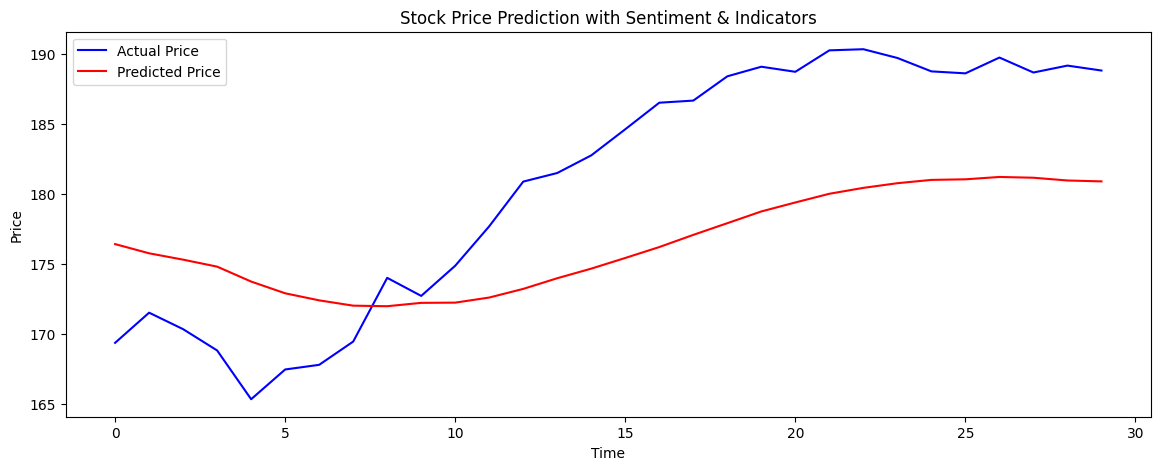

In [38]:
plt.figure(figsize=(14,5))
plt.plot(real_price, color='blue', label='Actual Price')
plt.plot(predicted_price, color='red', label='Predicted Price')
plt.legend()
plt.title('Stock Price Prediction with Sentiment & Indicators')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

NameError: name 'scaled_data' is not defined